In [1]:
# calculate kiwifruit 's each parts' mua, mus, with equal scale enlarge
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
# from scipy import signal
# from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential

In [2]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [33]:
dict0 = {-1: 'Xiao_1206\\kiwi_center_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_skin.txt',1:'Xiao_1206\\kiwi_hard_skin.txt'}
dict1 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_skin.txt',1:'Xiao_1206\\kiwi_hard_skin.txt'}
dict2 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_flesh.txt',1:'Xiao_1206\\kiwi_hard_flesh.txt'}
dict3 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_center.txt',1:'Xiao_1206\\kiwi_hard_center.txt'}
dict4 = {-1: 'Xiao_1206\\kiwi_whole_irf_ND10000.txt',0:'Xiao_1206\\kiwi_soft_skin.txt',1:'Xiao_1206\\kiwi_hard_skin.txt',
        2:'Xiao_1206\\kiwi_soft_flesh.txt',3:'Xiao_1206\\kiwi_hard_flesh.txt',4:'Xiao_1206\\kiwi_soft_center.txt',
         5:'Xiao_1206\\kiwi_hard_center.txt'}

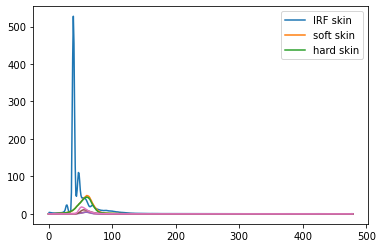

In [34]:
N = 7
scat = [None]*N
data_480multi9 = np.zeros((N,480), dtype = float)
for i in range(0,N):
    scat[i] = process_hyperspec(dict4[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index

line = [None]*N
plt.figure('ns/nm')
for i in range(0,N):
    line[i], = plt.plot(data_480multi9[i,:])

plt.legend(handles=[line[0],line[1],line[2]]
           ,labels=['IRF skin','soft skin','hard skin'],loc='best')
plt.show()
    

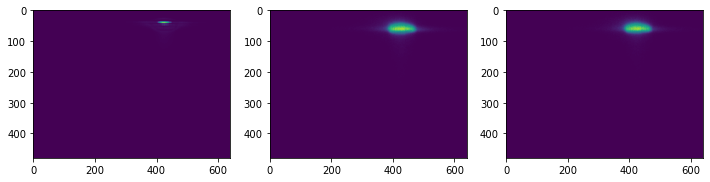

In [35]:
plt.figure(figsize= (12,3*12))
plt.subplot(1,3,1)
plt.imshow(scat[0].return_array())
plt.subplot(1,3,2)
plt.imshow(scat[1].return_array())
plt.subplot(1,3,3)
plt.imshow(scat[2].return_array())
plt.show()


In [36]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

In [37]:
data_intensity_extended = np.zeros((N, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]

In [11]:
h = data_480multi9[0,:] #x*h = y ; x.shape = (480,) h.shape = (480,) y.shape = (959,)


In [38]:
y =np.zeros((N,959))
for i in range(0,N):
    y[i,:] = data_intensity_extended[i,:]
    


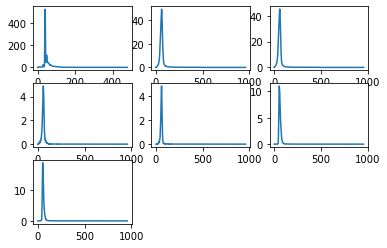

In [41]:
plt.subplot(3,3,1)
plt.plot(h)
for i in range(1,N):
    plt.subplot(3,3,i+1)
    plt.plot(y[i])

plt.show()

In [61]:
class calculate_miu_s(object):
    
    def __init__(self, h, y, time_index, k,d):
        self.h = h
        self.y = y
        self.time = time_index
        self.k = k
        self.d = d
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_s = x[0]
        miu_a = x[1]
        k = self.k
         
        # k = 0.1
        # miu_a = 0.01e2
        g = 0.85
        # d = 0.38e-3
        d = self.d*1e-3
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] - 1):

            intensity1[i] = calculate_miu_s.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.intensity = intensity1
        self.y_convolved = y2
        # y2 = y2/max(y2)
        y2 = y2*k*1e-9
        return np.sum(abs(y2 - self.y))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        
    def get_x(self):
        return self.intensity

In [90]:
def get_error(x):    
    k = x[0]
    d = np.array([0.38,0.53,11.6,5.55,13.79,16.86])
    m = [None]*(N-1)
    sum_fun = 0
    bnds = ((0, None), (0, None))
    for i in range(1,N):
        m[i-1] = calculate_miu_s(h, y[i], time_index, k,d[i-1])
        sum_fun = sum_fun + abs(minimize(m[i-1].error_cal, x0 = [3,3], method  = 'SLSQP',bounds=bnds, 
                                         options={"xtol" : 1e-20, "disp":True}).fun)
    return sum_fun

In [91]:
minimize(get_error, x0 = [0.3], method  = 'Nelder-Mead',bounds=(0,None)) #  method  = 'Nelder-Mead'

<ipython-input-90-3bbe7067f06d>:9: OptimizeWarning: Unknown solver options: xtol
  sum_fun = sum_fun + abs(minimize(m[i-1].error_cal, x0 = [3,3], method  = 'SLSQP',bounds=bnds,


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1111.7953396556634
            Iterations: 60
            Function evaluations: 241
            Gradient evaluations: 60
Optimization terminated successfully    (Exit mode 0)
            Current function value: 955.7534935426312
            Iterations: 78
            Function evaluations: 280
            Gradient evaluations: 77


<ipython-input-61-bcb41baa70da>:13: RuntimeWarning: divide by zero encountered in double_scalars
  Z0 = 1/(miu_s_prime)
<ipython-input-61-bcb41baa70da>:17: RuntimeWarning: invalid value encountered in double_scalars
  h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
<ipython-input-61-bcb41baa70da>:18: RuntimeWarning: invalid value encountered in double_scalars
  h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
<ipython-input-61-bcb41baa70da>:19: RuntimeWarning: invalid value encountered in double_scalars
  h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
<ipython-input-61-bcb41baa70da>:20: RuntimeWarning: invalid value encountered in double_scalars
  h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.65883539820364
            Iterations: 42
            Function evaluations: 169
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.4172823996962
            Iterations: 29
            Function evaluations: 119
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 96.4572036749851
            Iterations: 51
            Function evaluations: 205
            Gradient evaluations: 50
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.45179200246855
            Iterations: 54
            Function evaluations: 243
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1104.5030545512782
            Iterations: 69
            Function eval

<ipython-input-61-bcb41baa70da>:14: RuntimeWarning: divide by zero encountered in double_scalars
  D = 1/(3*(miu_a + miu_s_prime))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.11838902557767
            Iterations: 57
            Function evaluations: 235
            Gradient evaluations: 55
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1100.8970251590542
            Iterations: 80
            Function evaluations: 299
            Gradient evaluations: 78
Optimization terminated successfully    (Exit mode 0)
            Current function value: 941.6371802613459
            Iterations: 99
            Function evaluations: 362
            Gradient evaluations: 98
Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.54891707539296
            Iterations: 36
            Function evaluations: 160
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.2935821514343
            Iterations: 28
            Function eva

 final_simplex: (array([[0.32342983],
       [0.32342983]]), array([2365.56600788, 2365.56608657]))
           fun: 2365.566007879052
       message: 'Optimization terminated successfully.'
          nfev: 73
           nit: 33
        status: 0
       success: True
             x: array([0.32342983])

In [94]:
miu_s_get = np.zeros((N-1,2))
m = [None]*(N-1)
fun_value = np.zeros((N-1,))
d = np.array([0.38,0.53,11.6,5.55,13.79,16.86])
k = 0.323
bnds = ((0, None), (0, None))
for i in range(1,N):
    m[i-1] = calculate_miu_s(h, y[i], time_index, k,d[i-1])
    minu = minimize(m[i-1].error_cal, x0 = [3,6], method  = 'SLSQP', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
    miu_s_get[i-1,:], fun_value[i-1] = minu.x, minu.fun

<ipython-input-94-a1caa09f8b6d>:9: OptimizeWarning: Unknown solver options: xtol
  minu = minimize(m[i-1].error_cal, x0 = [3,6], method  = 'SLSQP', bounds = bnds, options={"xtol" : 1e-20, "disp":True})


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1100.6650478146562
            Iterations: 82
            Function evaluations: 345
            Gradient evaluations: 81
Optimization terminated successfully    (Exit mode 0)
            Current function value: 941.3564527294009
            Iterations: 88
            Function evaluations: 324
            Gradient evaluations: 86


<ipython-input-61-bcb41baa70da>:13: RuntimeWarning: divide by zero encountered in double_scalars
  Z0 = 1/(miu_s_prime)
<ipython-input-61-bcb41baa70da>:17: RuntimeWarning: invalid value encountered in double_scalars
  h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
<ipython-input-61-bcb41baa70da>:18: RuntimeWarning: invalid value encountered in double_scalars
  h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
<ipython-input-61-bcb41baa70da>:19: RuntimeWarning: invalid value encountered in double_scalars
  h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
<ipython-input-61-bcb41baa70da>:20: RuntimeWarning: invalid value encountered in double_scalars
  h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.54252126781398
            Iterations: 25
            Function evaluations: 113
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.290915703137166
            Iterations: 27
            Function evaluations: 104
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 95.7398643368442
            Iterations: 31
            Function evaluations: 135
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 133.4586838456263
            Iterations: 30
            Function evaluations: 149
            Gradient evaluations: 30


2366.0534856974787
[1100.66504781  941.35645273   47.54252127   47.2909157    95.73986434
  133.45868385]


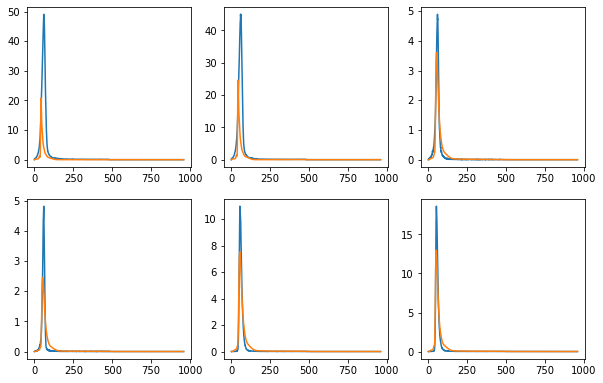

In [95]:
print(np.sum(abs(fun_value)))
print(fun_value)
plt.figure(figsize = (10,10))
for i in range (0, N-1):
    yk = m[i].get_convolved_signal()
    plt.subplot(3,3,i+1)
    plt.plot(y[i+1])
    plt.plot(yk*k*1e-9)
plt.show()

In [115]:
miu_s_get[:,1]=miu_s_get[:,1]*1e4

In [118]:
print('        mua             mus   [/m] \n')
print('skin: ',miu_s_get[0,],'\n')
print('      ',miu_s_get[1,],'\n')
print('flesh:',miu_s_get[2,],'\n')
print('      ',miu_s_get[3,],'\n')
print('center',miu_s_get[4,],'\n')
print('      ',miu_s_get[5,],'\n')

        mua             mus   [/m] 

skin:  [  300.41367211 32900.44000033] 

       [  170.90419754 30671.62563572] 

flesh: [1.80061469e+00 2.64304748e+05] 

       [7.52799966e+00 2.36837872e+05] 

center [1.22639556e+00 2.02405171e+05] 

       [6.59739196e-01 2.51843967e+05] 



In [124]:
print(miu_s_get)

[[0.97928388 1.63113221]
 [0.77216764 2.02663728]]


In [73]:
print(miu_s_get)

[[ 0.58911684 11.04065987]
 [ 0.55697056 10.20989281]]
